# Stand-alone driver of `LIM_AM_mod.py`

## Import modules

In [7]:
import math
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import os

import calendar
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline
mpl.rc('image', cmap='bwr')

from get_AM_mod import JRA55, CMIP6, ERA5, NAM, SAM, get_y
from tools_AM_mod import cov_lag, find_event
from LIM_AM_mod import LIM, rand_model, Myla
from stats_mod import stats_tests_normal, stats_tests_rand_model, bootstrap, bootstrap_model, StackArray

from numpy import linalg as la

with open("model_list.txt", "r") as f:
    model_list = f.readlines()
    model_list = [d.replace("\n", "") for d in model_list]
# model_list.remove("CESM2")
# D = D_list[model_list.index('HadGEM3-GC31-LL')]
# print(D.name)

plev = [850.,  700.,  500.,  250.,  100.,   50.,   10.]
len_slice = 150
offset = 40

## Load data
`Notations`
* y: original data
* y2: original data + padding of length `offset` before and after for composite analysis
* y3: data generated by random model

In [8]:
# data = JRA55(name_dir='jra_55', year_start=1958, year_end=2014, plev=plev, name='JRA55')
# 
data = ERA5(name_dir='ERA5', year_start=1950, year_end=2014, plev=plev, source_dir='cmip6')
data_y71 = ERA5(name_dir='ERA5', year_start=1950, year_end=2021, plev=plev, source_dir='cmip6')

data_z37 = ERA5(name_dir='ERA5', year_start=1950, year_end=2014, source_dir='cmip6')
data_z37_y71 = ERA5(name_dir='ERA5', year_start=1950, year_end=2021,source_dir='cmip6')

D, p, y, t, y2 = get_y(data, 'NAM', len_slice=len_slice, offset=offset)
D_y71, p_y71, y_y71, t_y71, y2_y71 = get_y(data_y71, 'NAM', len_slice=len_slice, offset=offset)
D_z37, p_z37, y_z37, t_z37, y2_z37 = get_y(data_z37, 'NAM', len_slice=len_slice, offset=offset)
D_z37_y71, p_z37_y71, y_z37_y71, t_z37_y71, y2_z37_y71 = get_y(data_z37_y71, 'NAM', len_slice=len_slice, offset=offset)


Calculating from the original data .......
ERA5 (65, 365, 7) 	calendar: 365_day
t.shape = (150,), y.shape = (64, 150, 7), y2.shape = (64, 230, 7)
Calculating from the original data .......
ERA5 (72, 365, 7) 	calendar: 365_day
t.shape = (150,), y.shape = (71, 150, 7), y2.shape = (71, 230, 7)
Calculating from the original data .......
ERA5 (65, 365, 37) 	calendar: 365_day
t.shape = (150,), y.shape = (64, 150, 37), y2.shape = (64, 230, 37)
Calculating from the original data .......
ERA5 (72, 365, 37) 	calendar: 365_day
t.shape = (150,), y.shape = (71, 150, 37), y2.shape = (71, 230, 37)


## Tests of codes

In [9]:
# from LIM_AM_mod import Gt_test, eig_m_test, LIM_test, rand_model_test

# hyp_param = dict(lim = dict(lag_time = 5,
#                            ),
#                 )
# print(f'hyperpamameters:\n{hyp_param}')

# # test of `cov_lag` and `pinv`
# Gt_test(y, hyp_param, verbose=True)

# # test of `eig_m`
# eig_m_test(y, hyp_param)


# # test of 'LIM' class
# hyp_param = dict(lim = dict(lag_time = 5,
#                             r_optimal = 5,
#                             eig_method = 'pinv',
#                             ord   = 1,
#                             )
#                 )
# print(f'hyperpamameters:\n{hyp_param}')
# LIM_test(y, t, hyp_param)


# # tests of rand_model function
# rand_model_test()

## EOFs

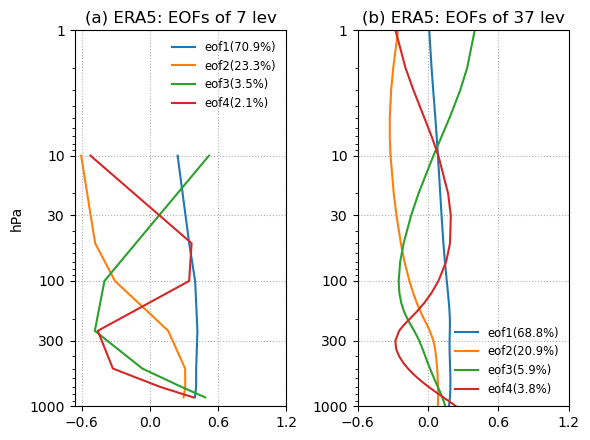

In [10]:
U, s, _ = Myla.svd(y)
s_prct = (s*s)[:4]/np.sum(s*s)*100

U_z37, s_z37, _ = Myla.svd(y_z37)
s_prct_z37 = (s_z37*s_z37)[:4]/np.sum(s_z37*s_z37)*100

fig = plt.figure(figsize=(6,4.5))
fig.add_subplot(1,2,1)
for eofi in range(4):
    plt.plot(U[:, eofi]/np.sign(U[-1, eofi]), p, '-', label=f'eof{eofi+1}({s_prct[eofi]:.1f}%)')
plt.ylim((1, 1000))
plt.gca().invert_yaxis()
plt.yscale('log')
plt.yticks([1, 10, 30, 100, 300, 1000])
plt.ylabel('hPa')
plt.xticks([-0.6, 0, 0.6, 1.2])
plt.legend(fontsize='small', loc='upper right', frameon=False)
plt.title('(a) ERA5: EOFs of 7 lev')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.grid(True, linestyle=':')

fig.add_subplot(1,2,2)
for eofi in range(4):
    plt.plot(U_z37[:, eofi]/np.sign(U_z37[-1, eofi]), p_z37, '-', label=f'eof{eofi+1}({s_prct_z37[eofi]:.1f}%)')
plt.ylim((1, 1000))
plt.gca().invert_yaxis()
plt.yscale('log')
plt.yticks([1, 10, 30, 100, 300, 1000])
# plt.ylabel('hPa')
plt.xticks([-0.6, 0, 0.6, 1.2])
plt.legend(fontsize='small', loc='lower right', frameon=False)
plt.title('(b) ERA5: EOFs of 37 lev')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.grid(True, linestyle=':')

plt.tight_layout()
# plt.savefig(f'Figs/LIM_eofs.pdf', transparent=True)


## Sensitivity to SVD truncation

In [11]:
def skills(model, y2):
    lag = hyp_param['lim']['lag_time']
    ord = hyp_param['lim']['ord']

    Gt = model.get_Gt(lag)
    Gt_norm = la.norm(Gt.flatten(), ord=ord)**ord

    # theoretical estimate
    LIM_err, LIM_R2 = model.LIM_skills(range(lag+1))

    # estimate from the testing dataset
    lags = np.arange(lag+1)
    y_err, y_R2 = model.forecast_offset(y2, lags, slice_offset=offset)
    
    # err, R2 = LIM_err[-1], LIM_R2[-1]
    err, R2 = y_err[-1], y_R2[-1]

    return Gt_norm, err, R2

def skills_r(y, y2, r_min, r_max):
    # y: training dataset; y2: testing dataset with slice_offset
    norm_r = np.empty((r_max-r_min+1, ))
    err_r = np.empty_like(norm_r)
    R2_r = np.empty_like(norm_r)
    b0_r = np.empty((r_max-r_min+1, ), dtype=complex)
    s_prct = np.empty_like(norm_r)
    for rr in range(r_min, r_max+1):
        hyp_param['lim']['r_optimal'] = rr
        model_r = LIM(y, hyp_param, verbose=False)
        norm_r[rr-r_min], err_r[rr-r_min], R2_r[rr-r_min] = skills(model_r, y2)
        b0_r[rr-r_min] = model_r.b[0]
        s_prct[rr-r_min] = model_r.s_prct

    return norm_r, err_r, R2_r, b0_r, s_prct

hyp_param = dict(lim = dict(lag_time = 5,
                            r_optimal = None,
                            eig_method = 'pinv',
                            ord   = 2,
                            )
                )

In [12]:
rmax = 7
y_testing = 64      # years starting from 2014 (y2*_y71) for testing

#---
lag = 5
hyp_param['lim']['lag_time'] = lag
r_r = range(2, rmax+1)
norm_r, err_r, R2_r, b0_r, s_prct_r = skills_r(y, y2_y71[y_testing:,:offset+len_slice,:], r_min=2, r_max=rmax)

r_z37 = range(2, rmax+1)
norm_z37, err_z37, R2_z37, b0_z37, s_prct_z37 = skills_r(y_z37, y2_z37_y71[y_testing:,:offset+len_slice,:], r_min=2, r_max=rmax)

#---
lag = 10
hyp_param['lim']['lag_time'] = lag
r_r = range(2, rmax+1)
norm_lag2_r, err_lag2_r, R2_lag2_r, b0_lag2_r, s_prct_lag2_r = skills_r(y, y2_y71[y_testing:,:offset+len_slice,:], r_min=2, r_max=rmax)

r_z37 = range(2, rmax+1)
norm_lag2_z37, err_lag2_z37, R2_lag2_z37, b0_lag2_z37, s_prct_lag2_z37 = skills_r(y_z37, y2_z37_y71[y_testing:,:offset+len_slice,:], r_min=2, r_max=rmax)

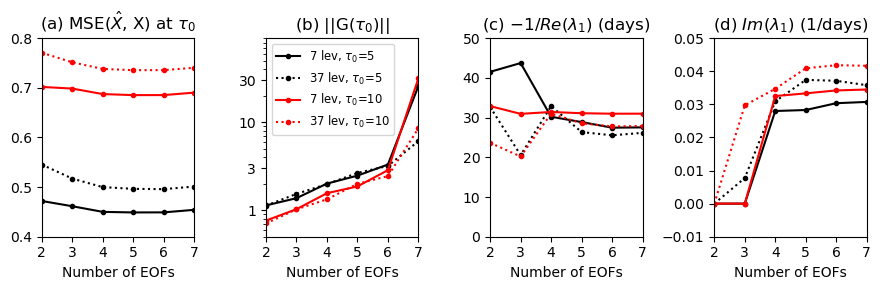

In [13]:
fig = plt.figure(figsize=(9,3))
fig.add_subplot(1,4,1)
plt.plot(r_r, err_r, '.k-', label=r'7 lev, $\tau_0$=5')
plt.plot(r_z37[:rmax-1], err_z37[:rmax-1], '.k:', label=r'37 lev, $\tau_0$=5')
plt.plot(r_r, err_lag2_r, '.r-', label=r'7 lev, $\tau_0$=10')
plt.plot(r_z37[:rmax-1], err_lag2_z37[:rmax-1], '.r:', label=r'37 lev, $\tau_0$=10')
plt.xticks(range(2, rmax+1, 1))
plt.xlim((2, rmax))
plt.xlabel('Number of EOFs')
plt.ylim((0.40, 0.80))
plt.title(r'(a) MSE($\hat{X}$, X) at $\tau_0$')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# plt.legend(fontsize='small')

fig.add_subplot(1,4,2)
plt.plot(r_r, norm_r, '.k-', label=r'7 lev, $\tau_0$=5')
plt.plot(r_z37[:rmax-1], norm_z37[:rmax-1], '.k:', label=r'37 lev, $\tau_0$=5')
plt.plot(r_r, norm_lag2_r, '.r-', label=r'7 lev, $\tau_0$=10')
plt.plot(r_z37[:rmax-1], norm_lag2_z37[:rmax-1], '.r:', label=r'37 lev, $\tau_0$=10')
plt.xticks(range(2, rmax+1, 1))
plt.xlim((2, rmax))
plt.xlabel('Number of EOFs')
plt.ylim((0.5, 90))
plt.yscale('log')
plt.yticks((1, 3, 10, 30))
plt.title(r'(b) ||G($\tau_0$)||')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.legend(fontsize='small')

fig.add_subplot(1,4,3)
plt.plot(r_r, -1/b0_r.real, '.k-')
plt.plot(r_z37[:rmax-1], -1/b0_z37[:rmax-1].real, '.k:')
plt.plot(r_r, -1/b0_lag2_r.real, '.r-')
plt.plot(r_z37[:rmax-1], -1/b0_lag2_z37[:rmax-1].real, '.r:')
plt.xticks(range(2, rmax+1, 1))
plt.xlim((2, rmax))
plt.xlabel('Number of EOFs')
plt.ylim((0, 50))
# plt.ylabel('days')
plt.title(r'(c) $-1/Re(\lambda_1)$ (days)')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# plt.legend()

fig.add_subplot(1,4,4)
plt.plot(r_r, b0_r.imag, '.k-')
plt.plot(r_z37[:rmax-1], b0_z37[:rmax-1].imag, '.k:')
plt.plot(r_r, b0_lag2_r.imag, '.r-')
plt.plot(r_z37[:rmax-1], b0_lag2_z37[:rmax-1].imag, '.r:')
plt.xticks(range(2, rmax+1, 1))
plt.xlim((2, rmax))
plt.xlabel('Number of EOFs')
plt.ylim((-0.01, 0.05))
# plt.ylabel('1/days')
plt.title(r'(d) $Im(\lambda_1)$ (1/days)')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# plt.legend()

plt.tight_layout()
# plt.savefig(f'Figs/LIM_SVDs.pdf', transparent=True)

## Tau test and error growth
* use a fixed number of SVDs

In [14]:
hyp_param = dict(lim = dict(lag_time = 5,
                            r_optimal = 4,    # use 4 SVDs
                            eig_method = 'pinv',
                            ord   = 2,
                            )
                )
print(f'hyperpamameters:\n{hyp_param}')

#=========================================
model = LIM(y, hyp_param, verbose=True)
model_z37 = LIM(y_z37, hyp_param, verbose=True)

#-----
y3 = rand_model(model.B_r, model.vr_Q, model.w_Q, len_day=len_slice*1000, dt=0.2, verbose=False, get_x_from_r=model.get_x_from_r)
# model3 = LIM(y3[None, :], hyp_param, verbose=False)

# decomposition by modes
y2_mode = model.mode(y2)
y3_mode = model.mode(y3)
# Define the strat-trop coupling mode
y2_strat = y2_mode[:,:,:,:2].sum(axis=3)
y3_strat = y3_mode[:,:,:2].sum(axis=2)

#-----
y3_z37 = rand_model(model_z37.B_r, model_z37.vr_Q, model_z37.w_Q, len_day=len_slice*1000, dt=0.2, verbose=False, get_x_from_r=model_z37.get_x_from_r)
# model3_z37 = LIM(y3_z37[None, :], hyp_param, verbose=False)

# decomposition by modes
y2_z37_mode = model_z37.mode(y2_z37)
y3_z37_mode = model_z37.mode(y3_z37)
# Define the strat-trop coupling mode
y2_z37_strat = y2_z37_mode[:,:,:,:2].sum(axis=3)
y3_z37_strat = y3_z37_mode[:,:,:2].sum(axis=2)

#=========================================
# use different lag times
lag = 10
hyp_param['lim']['lag_time'] = lag
model_lag2 = LIM(y, hyp_param, verbose=False)
model_lag2_z37 = LIM(y_z37, hyp_param, verbose=False)

hyperpamameters:
{'lim': {'lag_time': 5, 'r_optimal': 4, 'eig_method': 'pinv', 'ord': 2}}
POP e-folding timescales =30.1981, 30.1981, 7.8904, 4.2632
r_opt=4: % of var=99.806541, norm=2.006132, err=0.484062, R2=0.515938, s=1.070690
POP e-folding timescales =32.8707, 32.8707, 8.1410, 4.5534
r_opt=4: % of var=99.350754, norm=1.979424, err=0.526245, R2=0.473755, s=0.928513


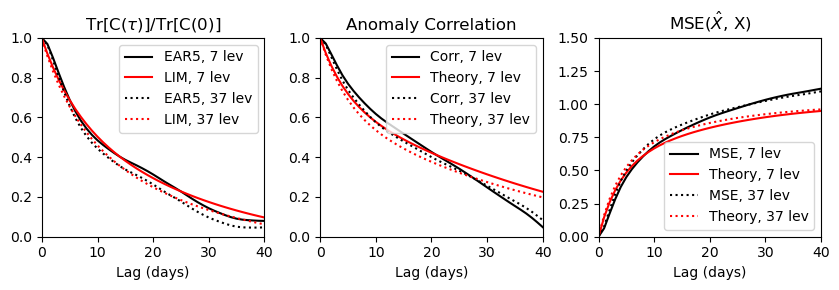

In [15]:
lag_time = 40
lags = np.arange(lag_time+1)
y_testing = 64

# Z8
C0 = cov_lag(y, lag_time=0)
Ct_trace = np.array([np.trace(cov_lag(y, lag)) for lag in lags])
Ctf_trace = np.trace(np.squeeze(model.forecast(C0, lags)), axis1=1, axis2=2)

y_err, y_R2 = model.forecast_offset(y2_y71[y_testing:,:offset+len_slice,:], lags, slice_offset=offset)
LIM_err, LIM_R2 = model.LIM_skills(lags)

# Z37
C0_z37 = cov_lag(y_z37, lag_time=0)
Ct_z37_trace = np.array([np.trace(cov_lag(y_z37, lag)) for lag in lags])
Ctf_z37_trace = np.trace(np.squeeze(model_z37.forecast(C0_z37, lags)), axis1=1, axis2=2)

y_z37_err, y_z37_R2 = model_z37.forecast_offset(y2_z37_y71[y_testing:,:offset+len_slice,:], lags, slice_offset=offset)
LIM_z37_err, LIM_z37_R2 = model_z37.LIM_skills(lags)

fig = plt.figure(figsize=(8.5,3))
fig.add_subplot(1, 3, 1)
plt.plot(lags, Ct_trace/np.trace(C0), 'k-', label='EAR5, 7 lev')
plt.plot(lags, Ctf_trace/np.trace(C0), 'r-', label='LIM, 7 lev')
plt.plot(lags, Ct_z37_trace/np.trace(C0_z37), 'k:', label='EAR5, 37 lev')
plt.plot(lags, Ctf_z37_trace/np.trace(C0_z37), 'r:', label='LIM, 37 lev')
plt.xlabel('Lag (days)')
plt.xlim((0, lag_time))
plt.ylim((0, 1.0))
plt.title(r'Tr[C($\tau$)]/Tr[C(0)]')
plt.legend()

fig.add_subplot(1, 3, 2)
plt.plot(lags, y_R2**0.5, 'k-', label=r'Corr, 7 lev')
plt.plot(lags, LIM_R2**0.5, 'r-', label='Theory, 7 lev')
plt.plot(lags, y_z37_R2**0.5, 'k:', label=r'Corr, 37 lev')
plt.plot(lags, LIM_z37_R2**0.5, 'r:', label=r'Theory, 37 lev')
plt.xlabel('Lag (days)')
plt.xlim((0, lag_time))
plt.ylim((0, 1.0))
plt.title(r'Anomaly Correlation')
plt.legend()

fig.add_subplot(1, 3, 3)
plt.plot(lags, y_err, 'k-', label=r'MSE, 7 lev')
plt.plot(lags, LIM_err, 'r-', label='Theory, 7 lev')
plt.plot(lags, y_z37_err, 'k:', label=r'MSE, 37 lev')
plt.plot(lags, LIM_z37_err, 'r:', label=r'Theory, 37 lev')
plt.xlabel('Lag (days)')
plt.xlim((0, lag_time))
plt.ylim((0, 1.5))
plt.title(r'MSE($\hat{X}$, X)')
plt.legend()

plt.tight_layout()
# plt.savefig('Figs/LIM_skills.pdf', transparent=True)

## Eigenvalues and eigenvectors

In [16]:
# bootstrap of eigenvalues and eigenvectors
hyp_param['lim']['lag_time'] = 5
print(f'hyperpamameters:\n{hyp_param}')
Stack_LIM = StackArray()

def stat_func(y, axis):
    model = LIM(y, hyp_param, verbose=False)
    Stack_LIM.add_array('b_r', model.b.real)
    Stack_LIM.add_array('b_i', model.b.imag)
    sn = np.sign(model.vr[p==500, 0].real)*la.norm(model.vr[:, 0])/np.sqrt(len(model.vr))
    Stack_LIM.add_array('vr_r', model.vr.real/sn)
    Stack_LIM.add_array('vr_i', model.vr.imag/sn)
    return Stack_LIM.stack()

ci_stacked, dis_stacked, se_stacked = bootstrap(y, statistic=stat_func, n_resamples=1000, confidence_level=0.95, random_state=42, method='percentile')

ci = (Stack_LIM.unstack(ci_stacked[0], 'low'), Stack_LIM.unstack(ci_stacked[1], 'high'))

hyperpamameters:
{'lim': {'lag_time': 5, 'r_optimal': 4, 'eig_method': 'pinv', 'ord': 2}}


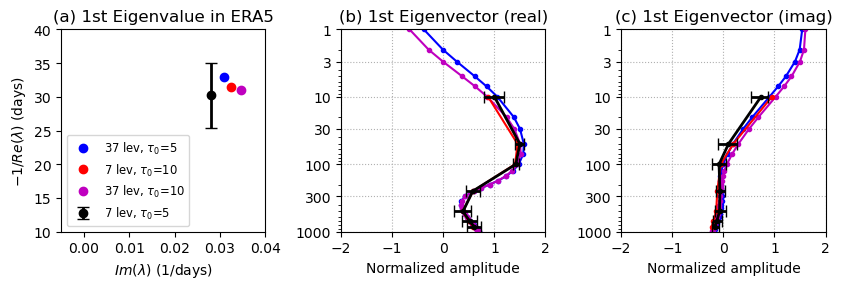

In [17]:
fig = plt.figure(figsize=(8.5,3))
sym = ['o', '^', 'd', 's', 'p', 'h']

fig.add_subplot(1,3,1)
markersize = 6
for mm in range(1): # range(len(model.b)):
    yerr = [[-1/model.b[mm].real + 1/ci[0].b_r[mm]], [-1/ci[1].b_r[mm] + 1/model.b[mm].real]]
    # xerr = [[model.b[mm].imag - ci[0].b_i[mm]], [ci[1].b_i[mm] - model.b[mm].imag]]
    plt.errorbar(model.b[mm].imag, -1/model.b[mm].real, yerr, fmt=sym[mm]+'k', linewidth=2, capsize=4, label=r'7 lev, $\tau_0$=5')

    plt.plot(model_z37.b[mm].imag, -1/model_z37.b[mm].real,  sym[mm]+'b',  ms=markersize, label=r'37 lev, $\tau_0$=5')
    plt.plot(model_lag2.b[mm].imag, -1/model_lag2.b[mm].real,  sym[mm]+'r',  ms=markersize, label=r'7 lev, $\tau_0$=10')
    plt.plot(model_lag2_z37.b[mm].imag, -1/model_lag2_z37.b[mm].real,  sym[mm]+'m', ms=markersize, label=r'37 lev, $\tau_0$=10')
    if mm == 0:
        plt.legend(fontsize='small', loc='lower left')

plt.xlim((-0.005, 0.04))
plt.xticks([0, 0.01, 0.02, 0.03, 0.04])
plt.ylim((10, 40))
plt.xlabel(r'$Im(\lambda)$ (1/days)')
plt.ylabel(r'$-1/Re(\lambda)$ (days)')
plt.title('(a) 1st Eigenvalue in ERA5')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

fig.add_subplot(1,3,2)
def get_sn(model, p):
    return np.sign(model.vr[p==500, 0].real)*la.norm(model.vr[:, 0])/np.sqrt(len(model.vr))
sn = get_sn(model,p)
sn_z37 = get_sn(model_z37, p_z37)
sn_lag2 = get_sn(model_lag2, p)
sn_lag2_z37 = get_sn(model_lag2_z37, p_z37)

eig0 = model.vr[:, 0].real/sn
xerr = [eig0-ci[0].vr_r[:,0], ci[1].vr_r[:,0]-eig0]
plt.errorbar(eig0, p, xerr=xerr, fmt='-k.', linewidth=2, capsize=4, zorder=4, label=r'7 lev, $\tau_0$=5')
# plt.fill_betweenx(p, ci[0].vr_r[:, 0], ci[1].vr_r[:, 0], color='green',zorder=5, alpha=0.3)
plt.plot(model_z37.vr[:, 0].real/sn_z37, p_z37,  '-b.', label=r'37 lev, $\tau_0$=5')
plt.plot(model_lag2.vr[:, 0].real/sn_lag2, p,  '-r.', zorder=3, label=r'7 lev, $\tau_0$=10')
plt.plot(model_lag2_z37.vr[:, 0].real/sn_lag2_z37, p_z37,  '-m.', label=r'37 lev, $\tau_0$=10')

plt.ylim((1, 1000))
plt.gca().invert_yaxis()
plt.xlabel('Normalized amplitude')
# plt.ylabel('Pressure (hPa)')
plt.xlim((-2, 2))
plt.xticks([-2, -1, 0, 1, 2])
plt.yscale('log')
plt.yticks([1, 3, 10, 30, 100, 300, 1000])
plt.grid(linestyle=':')
plt.title('(b) 1st Eigenvector (real)')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# plt.legend()

fig.add_subplot(1,3,3)
eig0 = model.vr[:, 0].imag/sn
xerr = [eig0-ci[0].vr_i[:,0], ci[1].vr_i[:,0]-eig0]
plt.errorbar(eig0, p, xerr=xerr, fmt='-k.', linewidth=2, capsize=4, zorder=4, label=r'7 lev, $\tau_0$=5')
# plt.fill_betweenx(p, ci[0].vr_i[:, 0], ci[1].vr_i[:, 0], color='green', zorder=5, alpha=0.3)
plt.plot(model_z37.vr[:, 0].imag/sn_z37, p_z37,  '-b.', label=r'37 lev, $\tau_0$=5')
plt.plot(model_lag2.vr[:, 0].imag/sn_lag2, p,  '-r.', zorder=3, label=r'7 lev, $\tau_0$=10')
plt.plot(model_lag2_z37.vr[:, 0].imag/sn_lag2_z37, p_z37,  '-m.', label=r'37 lev, $\tau_0$=10')

plt.ylim((1, 1000))
plt.gca().invert_yaxis()
plt.xlabel('Normalized amplitude')
# plt.ylabel('Pressure (hPa)')
plt.xlim((-2, 2))
plt.xticks([-2, -1, 0, 1, 2])
plt.yscale('log')
plt.yticks([1, 3, 10, 30, 100, 300, 1000])
plt.grid(linestyle=':')
plt.title('(c) 1st Eigenvector (imag)')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# plt.legend()

plt.tight_layout()
# plt.savefig('Figs/LIM_eigs.pdf', transparent=True)

## Lagged regression

In [18]:
def cal_Ct_p(y, p, p_level):
    k = np.isin(p, p_level)
    Ct_p = np.array([cov_lag(y, lag, -y[:, :, k]) for lag in lags])
    Ct_p_lag = np.array([cov_lag(-y[:, :, k], lag, y) for lag in lags])
    return Ct_p, Ct_p_lag

lag_time = 40
lags = range(lag_time+1)
lags2= range(-lag_time, lag_time+1)
Ct_p0, Ct_p0_lag = cal_Ct_p(y, p, p_level=10)
Ct_p3, Ct_p3_lag = cal_Ct_p(y3[None, :], p, p_level=10)  # using data from the random model

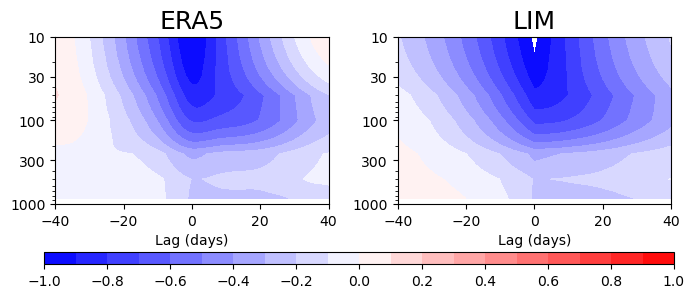

In [19]:
def plot_lag_reg(name, p, Ct_p0, Ct_p0_lag):
    plt.contourf(lags2, p, np.vstack((np.flipud(Ct_p0_lag[1:,:]), Ct_p0)).T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    # plt.plot(np.zeros_like(p), p, '-k')
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    # plt.ylabel('hPa')
    plt.xticks([-40, -20, 0, 20, 40])
    plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name, fontsize=18)

cm = 'bwr' # 'seismic' # 'RdBu_r'
fig = plt.figure(figsize=(7,3))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 1, 11
ax1 = fig.add_subplot(1, 2, 1)
plot_lag_reg('ERA5', p, Ct_p0, Ct_p0_lag)
ax1 = fig.add_subplot(1, 2, 2)
plot_lag_reg('LIM', p, Ct_p3, Ct_p3_lag)

plt.tight_layout()
fig.subplots_adjust(bottom=0.3)
cax = fig.add_axes([0.07, 0.1, 0.90, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_reg_ERA5_LIM.pdf', transparent=True)

## Weak vortex events - 7 levels

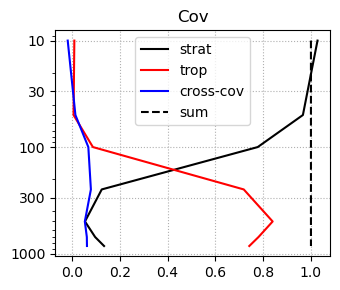

In [20]:
y2_trop = y2 - y2_strat

r2_strat = np.empty(len(p))
r2_trop = np.empty(len(p))
r2_strat_trop = np.empty(len(p))
for k in range(len(p)):
    r2_strat[k] = cov_lag(y2_strat[:,offset:offset+len_slice,k], lag_time=0, X2=y2_strat[:,offset:offset+len_slice,k])
    r2_trop[k] = cov_lag(y2_trop[:,offset:offset+len_slice,k], lag_time=0, X2=y2_trop[:,offset:offset+len_slice,k])
    r2_strat_trop[k] = cov_lag(y2_strat[:,offset:offset+len_slice,k], lag_time=0, X2=y2_trop[:,offset:offset+len_slice,k])
    
fig = plt.figure(figsize=(3.5,3))
plt.plot(r2_strat, p, '-k', label='strat')
plt.plot(r2_trop, p, '-r', label='trop')
plt.plot(r2_strat_trop, p, '-b', label='cross-cov')
plt.plot(r2_strat+r2_trop+2*r2_strat_trop, p, '--k', label='sum')

plt.gca().invert_yaxis()
plt.yscale('log')
plt.yticks([10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title('Cov')
plt.grid(linestyle=':')
plt.legend()

plt.tight_layout()
# plt.savefig('Figs/AM_event_ERA5_corr.pdf', transparent=True)

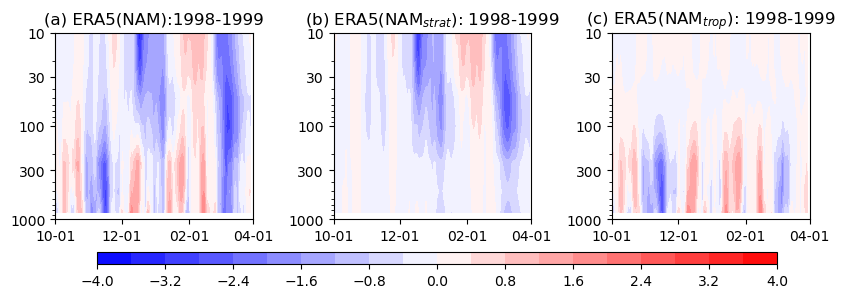

In [21]:
def plot_snapshot(name, p, y2):
    plt.contourf(time, p, y2.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.xlim([time[9], time[-1]])
    plt.xticks(mdates.date2num([dt.date(year, 10, 1), dt.date(year, 12, 1), 
                                dt.date(year+1, 2, 1), dt.date(year+1, 4, 1)]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name)

year = 1998
d_start = mdates.date2num(dt.date(year, 9, 22))
if calendar.isleap(year+1):
    d_end = mdates.date2num(dt.date(year+1, 3, 29))
else:
    d_end = mdates.date2num(dt.date(year+1, 3, 30))
time = np.linspace(d_start, d_end, round(d_end-d_start+1))
yi = year - D.data.year_start

cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(8.5, 3))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 4, 11
ax1 = fig.add_subplot(1, 3, 1)
# plot_snapshot(f"ERA5({year}-{year+1})", p, y2[yi, :offset+len_slice, :])
plot_snapshot(f"(a) ERA5(NAM):{year}-{year+1}", p, y2[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(1, 3, 2)
# plot_snapshot(f"ERA5(strat)", p, y2_strat[yi, :offset+len_slice, :])
plot_snapshot(r"(b) ERA5(NAM$_{strat}$): " + f"{year}-{year+1}", p, y2_strat[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(1, 3, 3)
y2_trop = y2 - y2_strat
# plot_snapshot(f"ERA5(trop)", p, y2_trop[yi, :offset+len_slice, :])
plot_snapshot(r"(c) ERA5(NAM$_{trop}$): " + f"{year}-{year+1}", p, y2_trop[yi, :offset+len_slice, :])

plt.tight_layout()
fig.subplots_adjust(bottom=0.25)
cax = fig.add_axes([0.12, 0.1, 0.80, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_event_ERA5_snapshot.pdf', transparent=True)

## Weak vortex events - 37 levels

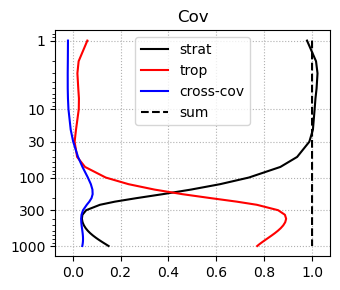

In [22]:
y2_z37_trop = y2_z37 - y2_z37_strat

r2_z37_strat = np.empty(len(p_z37))
r2_z37_trop = np.empty(len(p_z37))
r2_z37_strat_trop = np.empty(len(p_z37))
for k in range(len(p_z37)):
    r2_z37_strat[k] = cov_lag(y2_z37_strat[:,offset:offset+len_slice,k], lag_time=0, X2=y2_z37_strat[:,offset:offset+len_slice,k])
    r2_z37_trop[k] = cov_lag(y2_z37_trop[:,offset:offset+len_slice,k], lag_time=0, X2=y2_z37_trop[:,offset:offset+len_slice,k])
    r2_z37_strat_trop[k] = cov_lag(y2_z37_strat[:,offset:offset+len_slice,k], lag_time=0, X2=y2_z37_trop[:,offset:offset+len_slice,k])
    
fig = plt.figure(figsize=(3.5,3))
plt.plot(r2_z37_strat, p_z37, '-k', label='strat')
plt.plot(r2_z37_trop, p_z37, '-r', label='trop')
plt.plot(r2_z37_strat_trop, p_z37, '-b', label='cross-cov')
plt.plot(r2_z37_strat+r2_z37_trop+2*r2_z37_strat_trop, p_z37, '--k', label='sum')
plt.gca().invert_yaxis()
plt.yscale('log')
plt.yticks([1, 10, 30, 100, 300, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.title('Cov')
plt.grid(linestyle=':')
plt.legend()

plt.tight_layout()
# plt.savefig('Figs/AM_event_ERA5_corr_z37.pdf', transparent=True)

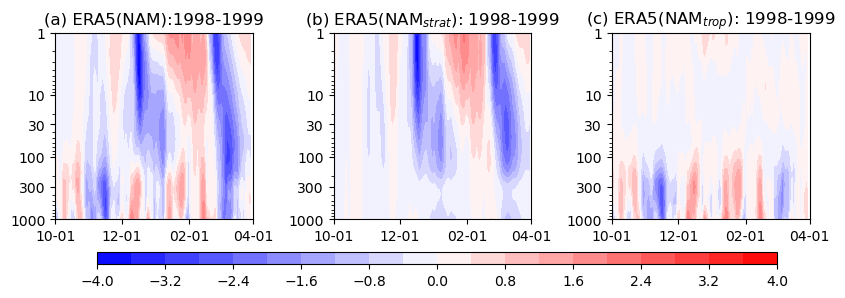

In [23]:
def plot_snapshot(name, p, y2):
    plt.contourf(time, p, y2.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([1, 10, 30, 100, 300, 1000])
    plt.xlim([time[9], time[-1]])
    plt.xticks(mdates.date2num([dt.date(year, 10, 1), dt.date(year, 12, 1), 
                                dt.date(year+1, 2, 1), dt.date(year+1, 4, 1)]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name)

year = 1998
d_start = mdates.date2num(dt.date(year, 9, 22))
if calendar.isleap(year+1):
    d_end = mdates.date2num(dt.date(year+1, 3, 29))
else:
    d_end = mdates.date2num(dt.date(year+1, 3, 30))
time = np.linspace(d_start, d_end, round(d_end-d_start+1))
yi = year - D.data.year_start

cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(8.5, 3))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 4, 11
ax1 = fig.add_subplot(1, 3, 1)
plot_snapshot(f"(a) ERA5(NAM):{year}-{year+1}", p_z37, y2_z37[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(1, 3, 2)
plot_snapshot(r"(b) ERA5(NAM$_{strat}$): " + f"{year}-{year+1}", p_z37, y2_z37_strat[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(1, 3, 3)
y2_z37_trop = y2_z37 - y2_z37_strat
plot_snapshot(r"(c) ERA5(NAM$_{trop}$): " + f"{year}-{year+1}", p_z37, y2_z37_trop[yi, :offset+len_slice, :])

plt.tight_layout()
fig.subplots_adjust(bottom=0.25)
cax = fig.add_axes([0.12, 0.1, 0.80, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_event_ERA5_snapshot_z37.pdf', transparent=True)

## Event composites

In [24]:
lag_time = 40
threshold = -2
# threshold = 1.5
lags = np.arange(lag_time+1)
lags2= range(-lag_time, lag_time+1)

y2_event, y2_num = find_event(y, p, y2=y2, threshold=threshold, lag_time=lag_time)
y2_strat_event, y2_num = find_event(y, p, y2=y2_strat, threshold=threshold, lag_time=lag_time)

y3_event, y3_num = find_event(y3[None, lag_time:-lag_time], p, y2=y3[None,:], threshold=threshold, lag_time=lag_time)
y3_strat_event, y3_num = find_event(y3[None, lag_time:-lag_time], p, y2=y3_strat[None,:], threshold=threshold, lag_time=lag_time)

# of events: 35(0.55)
# of events: 35(0.55)
# of events: 402(402.00)
# of events: 402(402.00)


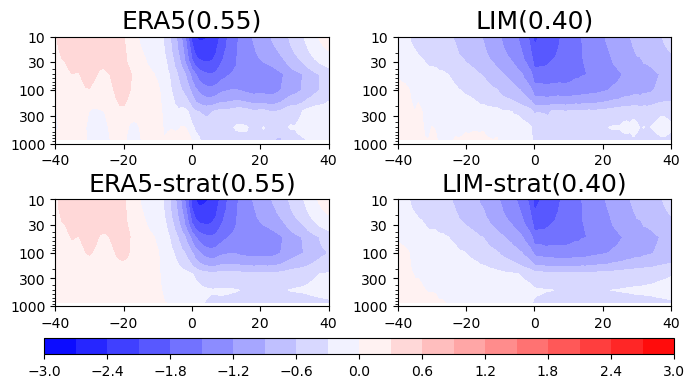

In [25]:
def plot_event(name, p, y0_event):
    plt.contourf(lags2, p, y0_event.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    # plt.plot(np.zeros_like(p), p, '-k')
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    # plt.ylabel('hPa')
    plt.xticks([-40, -20, 0, 20, 40])
    # plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name, fontsize=18)

cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(7,4))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 3, 11
ax1 = fig.add_subplot(2, 2, 1)
plot_event(f"ERA5({y2_num/(2014-1950):.2f})", p, y2_event)

ax1 = fig.add_subplot(2, 2, 2)
plot_event(f"LIM({y3_num/1000:.2f})", p, y3_event)

ax1 = fig.add_subplot(2, 2, 3)
plot_event(f"ERA5-strat({y2_num/(2014-1950):.2f})", p, y2_strat_event)

ax1 = fig.add_subplot(2, 2, 4)
plot_event(f"LIM-strat({y3_num/1000:.2f})", p, y3_strat_event)

plt.tight_layout()
fig.subplots_adjust(bottom=0.22)
cax = fig.add_axes([0.07, 0.1, 0.90, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))
# mpl.rcParams.update({'font.size': 18})

# plt.savefig('Figs/AM_event_ERA5_LIM.pdf', transparent=True)

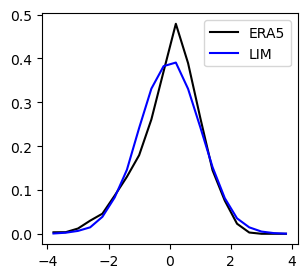

In [26]:
fig = plt.figure(figsize=(3.3,3))
bin_e = np.linspace(-4, 4, 21)
bin_c = 0.5 * (bin_e[:-1] + bin_e[1:])

his_c, _ = np.histogram(y[:, :, 0].flatten(), bins=bin_e, density=True)
his3_c, _ = np.histogram(y3[:, 0], bins=bin_e, density=True)

plt.plot(bin_c, his_c, '-k', label='ERA5')
plt.plot(bin_c, his3_c, '-b', label='LIM')
plt.legend()
